In [11]:
# Import our dependencies
from pymongo import MongoClient
from pprint import pprint
from tabulate import tabulate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE

In [12]:
# Connect to MongoDB Atlas
client = MongoClient("mongodb://localhost:27017/")

# Access the 'remote' database
db = client['remote']

# Fetch data from the 'record_df_df_dfs' collection
data_cursor = db['records'].find()
data_list = list(data_cursor)
data_df = pd.DataFrame(data_list)  # Convert to DataFrame

# Fetch data from the 'credit' collection
record_cursor = db['credit'].find()
record_list = list(record_cursor)
record_df = pd.DataFrame(record_list)  # Convert to DataFrame


In [13]:
data_df.head()

,_id,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,OCCUPATION_TYPE
0,675f8698c31b872d695d0afe,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,NaN
1,675f8698c31b872d695d0aff,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,NaN
2,675f8698c31b872d695d0b00,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0,Security staff
3,675f8698c31b872d695d0b01,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,Sales staff
4,675f8698c31b872d695d0b02,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,Sales staff


In [14]:
record_df.head()

,_id,ID,MONTHS_BALANCE,STATUS
0,675f86dbc31b872d6963bc21,5001711,0,X
1,675f86dbc31b872d6963bc22,5001711,-1,0
2,675f86dbc31b872d6963bc23,5001711,-2,0
3,675f86dbc31b872d6963bc24,5001711,-3,0
4,675f86dbc31b872d6963bc25,5001712,0,C


In [15]:
# Group and process the 'credit' collection DataFrame
begin_month = record_df.groupby("ID")["MONTHS_BALANCE"].agg(min).reset_index()
begin_month = begin_month.rename(columns={'MONTHS_BALANCE': 'begin_month'})

# Merge the DataFrames on the 'ID' column
merged_df = pd.merge(data_df, begin_month, how="left", on="ID")
merged_df = pd.DataFrame(merged_df)

# Show the first few rows of the merged DataFrame
print(merged_df.head())

                        _id       ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0  675f8698c31b872d695d0afe  5008804           M            Y               Y   
1  675f8698c31b872d695d0aff  5008805           M            Y               Y   
2  675f8698c31b872d695d0b00  5008806           M            Y               Y   
3  675f8698c31b872d695d0b01  5008808           F            N               Y   
4  675f8698c31b872d695d0b02  5008809           F            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL      NAME_INCOME_TYPE  \
0             0          427500.0               Working   
1             0          427500.0               Working   
2             0          112500.0               Working   
3             0          270000.0  Commercial associate   
4             0          270000.0  Commercial associate   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0               Higher education        Civil marriage   Rented apartment   
1   

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5500\2429288361.py:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  begin_month = record_df.groupby("ID")["MONTHS_BALANCE"].agg(min).reset_index()


In [16]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _id                  438557 non-null  object 
 1   ID                   438557 non-null  int64  
 2   CODE_GENDER          438557 non-null  object 
 3   FLAG_OWN_CAR         438557 non-null  object 
 4   FLAG_OWN_REALTY      438557 non-null  object 
 5   CNT_CHILDREN         438557 non-null  int64  
 6   AMT_INCOME_TOTAL     438557 non-null  float64
 7   NAME_INCOME_TYPE     438557 non-null  object 
 8   NAME_EDUCATION_TYPE  438557 non-null  object 
 9   NAME_FAMILY_STATUS   438557 non-null  object 
 10  NAME_HOUSING_TYPE    438557 non-null  object 
 11  DAYS_BIRTH           438557 non-null  int64  
 12  DAYS_EMPLOYED        438557 non-null  int64  
 13  FLAG_MOBIL           438557 non-null  int64  
 14  FLAG_WORK_PHONE      438557 non-null  int64  
 15  FLAG_PHONE       

In [17]:
# Find all users' account open month
begin_month = record_df.groupby("ID", as_index=False)["MONTHS_BALANCE"].agg("min")
begin_month = begin_month.rename(columns={"MONTHS_BALANCE": "begin_month"})

# Merge with the main dataset
new_data = pd.merge(data_df, begin_month, how="left", on="ID")

In [18]:
# Add a column to identify past due payments
record_df['past_due'] = 'No'  # Default to 'No'
record_df.loc[record_df['STATUS'].isin([2, 3, 4, 5]), 'past_due'] = 'Yes'

# Group by 'ID' to determine if any record is past due
risk_factor = record_df.groupby('ID', as_index=False)['past_due'].agg(
    lambda x: 'Yes' if 'Yes' in x.values else 'No'
)

# Debug: Ensure 'cpunt' contains 'past_due'
print("risk_factor columns:", risk_factor.columns)
print(risk_factor.head())

# Merge with new_data
new_data = pd.merge(new_data, risk_factor, how='inner', on='ID')

# Debug: Ensure 'past_due' exists in new_data
print("new_data columns:", new_data.columns)
print(new_data.head())

# Map 'Yes' and 'No' to numeric targets
if 'past_due' in new_data.columns:
    new_data['target'] = new_data['past_due'].map({'Yes': 1, 'No': 0})
else:
    print("Error: 'past_due' column is missing in new_data.")


risk_factor columns: Index(['ID', 'past_due'], dtype='object')
        ID past_due
0  5001711       No
1  5001712       No
2  5001713       No
3  5001714       No
4  5001715       No
new_data columns: Index(['_id', 'ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'OCCUPATION_TYPE',
       'begin_month', 'past_due'],
      dtype='object')
                        _id       ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0  675f8698c31b872d695d0afe  5008804           M            Y               Y   
1  675f8698c31b872d695d0aff  5008805           M            Y               Y   
2  675f8698c31b872d695d0b00  5008806           M            Y               Y   
3  675f8698c31b872d695d0b01  5008808           F            N       

In [19]:
print(risk_factor['past_due'].value_counts())
risk_factor['past_due'].value_counts(normalize=True)

past_due
No     45318
Yes      667
Name: count, dtype: int64


past_due
No     0.985495
Yes    0.014505
Name: proportion, dtype: float64

In [20]:
print(record_df['past_due'].value_counts())

past_due
No     1045471
Yes       3104
Name: count, dtype: int64


In [21]:
# Create a binary target variable (1 for high-risk customers, 0 otherwise)
print(new_data['target'].value_counts())

target
0    35841
1      616
Name: count, dtype: int64


In [22]:
risk_factor = record_df.groupby('ID', as_index=False)['past_due'].agg(
    lambda x: 'Yes' if 'Yes' in x.values else 'No'
)
print(new_data['ID'].dtype)
print(risk_factor['ID'].dtype)

int64
int64


# Check for missing values in 'past_due'
na_count = new_data['past_due'].isna().sum()
print(f"Number of missing values in 'past_due': {na_count}")

In [24]:
yes_count = (risk_factor['past_due'] == 'Yes').sum()
no_count = (risk_factor['past_due'] == 'No').sum()

print(f"Yes: {yes_count}")
print(f"No: {no_count}")

Yes: 667
No: 45318


In [25]:
new_data = new_data.rename(columns={
    "ID": "ID",
    "CODE_GENDER": "GENDER",
    "FLAG_OWN_CAR": "OWN CAR",
    "FLAG_OWN_REALTY": "OWN REALTY",
    "CNT_CHILDREN": "CHILDREN",
    "AMT_INCOME_TOTAL": "INCOME TOTAL",
    "NAME_INCOME_TYPE": "INCOME TYPE",
    "NAME_EDUCATION_TYPE": "EDUCATION TYPE",
    "NAME_FAMILY_STATUS": "FAMILY STATUS",
    "NAME_HOUSING_TYPE": "HOUSING TYPE",
    "DAYS_BIRTH": "DAYS SINCE BIRTH",
    "DAYS_EMPLOYED": "DAYS EMPLOYED",
    "FLAG_MOBIL": "MOBIL",
    "FLAG_WORK_PHONE": "WORK PHONE",
    "FLAG_PHONE": "PHONE",
    "FLAG_EMAIL": "EMAIL",
    "OCCUPATION_TYPE": "TYPE",
    "CNT_FAM_MEMBERS": "FAM MEMBERS"
})

In [26]:
print(new_data.columns)

Index(['_id', 'ID', 'GENDER', 'OWN CAR', 'OWN REALTY', 'CHILDREN',
       'INCOME TOTAL', 'INCOME TYPE', 'EDUCATION TYPE', 'FAMILY STATUS',
       'HOUSING TYPE', 'DAYS SINCE BIRTH', 'DAYS EMPLOYED', 'MOBIL',
       'WORK PHONE', 'PHONE', 'EMAIL', 'FAM MEMBERS', 'TYPE', 'begin_month',
       'past_due', 'target'],
      dtype='object')


In [27]:
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna()

In [28]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25134 entries, 2 to 36456
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               25134 non-null  object 
 1   ID                25134 non-null  int64  
 2   GENDER            25134 non-null  object 
 3   OWN CAR           25134 non-null  object 
 4   OWN REALTY        25134 non-null  object 
 5   CHILDREN          25134 non-null  int64  
 6   INCOME TOTAL      25134 non-null  float64
 7   INCOME TYPE       25134 non-null  object 
 8   EDUCATION TYPE    25134 non-null  object 
 9   FAMILY STATUS     25134 non-null  object 
 10  HOUSING TYPE      25134 non-null  object 
 11  DAYS SINCE BIRTH  25134 non-null  int64  
 12  DAYS EMPLOYED     25134 non-null  int64  
 13  MOBIL             25134 non-null  int64  
 14  WORK PHONE        25134 non-null  int64  
 15  PHONE             25134 non-null  int64  
 16  EMAIL             25134 non-null  int64  
 17

In [29]:
# Create a DataFrame with column names and initialize 'IV' with None
ivtable = pd.DataFrame({'variable': new_data.columns, 'IV': None})

# List of variables to exclude
namelist = ['MOBIL', 'begin_month', 'past_due', 'target', 'ID']

# Drop rows where the 'variable' is in the namelist
ivtable = ivtable[~ivtable['variable'].isin(namelist)].reset_index(drop=True)


The function calculates the Information Value (IV) of a feature relative to a target variable. Information Value is a measure used in predictive modeling to evaluate the predictive power of a feature. It is commonly used in credit scoring and binary classification problems.

Function Workflow:
Input Parameters:

df: The DataFrame containing the feature and target variable.<br>
feature: The column name of the feature for which IV is being calculated.<br>
target: The column name of the target variable (binary: 0 or 1).<br>
pr: A boolean flag to print intermediate data and the IV score.

In [31]:
# Updated Function
def calc_iv(df, feature, target, pr=False):
    # Handle missing values in a way compatible with categorical data
    if df[feature].dtype.name == "category":
        # Add "NULL" as a category if not already present
        if "NULL" not in df[feature].cat.categories:
            df[feature] = df[feature].cat.add_categories("NULL")
    # Replace missing values with "NULL"
    df[feature] = df[feature].fillna("NULL")

    lst = []

    # Iterate over unique feature values
    for val in df[feature].unique():
        all_count = df[df[feature] == val].shape[0]
        good_count = df[(df[feature] == val) & (df[target] == 0)].shape[0]  # Good (e.g., target == 0)
        bad_count = df[(df[feature] == val) & (df[target] == 1)].shape[0]   # Bad (e.g., target == 1)

        lst.append([feature, val, all_count, good_count, bad_count])

    # Convert to DataFrame
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    # Calculate shares and distributions
    total_good = data['Good'].sum()
    total_bad = data['Bad'].sum()
    epsilon = 1e-10  # Small constant to prevent division by zero

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / (data['All'] + epsilon)
    data['Distribution Good'] = data['Good'] / (total_good + epsilon)
    data['Distribution Bad'] = data['Bad'] / (total_bad + epsilon)

    # Calculate Weight of Evidence (WoE)
    data['WoE'] = np.log((data['Distribution Good'] + epsilon) / (data['Distribution Bad'] + epsilon))
    data.replace({'WoE': {np.inf: 0, -np.inf: 0}}, inplace=True)  # Replace infinite values with 0

    # Calculate Information Value (IV)
    data['IV'] = (data['Distribution Good'] - data['Distribution Bad']) * data['WoE']

    # Sort data
    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True]).reset_index(drop=True)

    # Print results if needed
    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    # Calculate total IV
    iv = data['IV'].sum()
    print('This variable\'s IV is:', iv)
    print(df[feature].value_counts())

    return iv, data


In [32]:
yes_count = (risk_factor['past_due'] == 'Yes').sum()
no_count = (risk_factor['past_due'] == 'No').sum()

print(f"Yes: {yes_count}")
print(f"No: {no_count}")

Yes: 667
No: 45318


In [33]:
print(new_data['target'].value_counts())


target
0    24712
1      422
Name: count, dtype: int64


In [34]:
print(new_data.info())
print(new_data.head())

<class 'pandas.core.frame.DataFrame'>
Index: 25134 entries, 2 to 36456
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               25134 non-null  object 
 1   ID                25134 non-null  int64  
 2   GENDER            25134 non-null  object 
 3   OWN CAR           25134 non-null  object 
 4   OWN REALTY        25134 non-null  object 
 5   CHILDREN          25134 non-null  int64  
 6   INCOME TOTAL      25134 non-null  float64
 7   INCOME TYPE       25134 non-null  object 
 8   EDUCATION TYPE    25134 non-null  object 
 9   FAMILY STATUS     25134 non-null  object 
 10  HOUSING TYPE      25134 non-null  object 
 11  DAYS SINCE BIRTH  25134 non-null  int64  
 12  DAYS EMPLOYED     25134 non-null  int64  
 13  MOBIL             25134 non-null  int64  
 14  WORK PHONE        25134 non-null  int64  
 15  PHONE             25134 non-null  int64  
 16  EMAIL             25134 non-null  int64  
 17

In [35]:
iv, data = calc_iv(df=new_data, feature='GENDER', target='target', pr=True)


  Variable Value    All   Good  Bad     Share  Bad Rate  Distribution Good  \
0   GENDER     F  15630  15400  230  0.621867  0.014715           0.623179   
1   GENDER     M   9504   9312  192  0.378133  0.020202           0.376821   

   Distribution Bad       WoE        IV  
0          0.545024  0.134005  0.010473  
1          0.454976 -0.188475  0.014730  
IV =  0.025203504522086508
This variable's IV is: 0.025203504522086508
GENDER
F    15630
M     9504
Name: count, dtype: int64


In [36]:
new_data['GENDER'] = new_data['GENDER'].replace(['F','M'],[0,1])
print(new_data['GENDER'].value_counts())
iv, data = calc_iv(new_data,'GENDER','target')
ivtable.loc[ivtable['variable']=='GENDER','IV']=iv
data.head()

GENDER
0    15630
1     9504
Name: count, dtype: int64
This variable's IV is: 0.025203504522086508
GENDER
0    15630
1     9504
Name: count, dtype: int64


C:\Users\Administrator\AppData\Local\Temp\ipykernel_5500\1154117438.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_data['GENDER'] = new_data['GENDER'].replace(['F','M'],[0,1])


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,GENDER,0,15630,15400,230,0.621867,0.014715,0.623179,0.545024,0.134005,0.010473
1,GENDER,1,9504,9312,192,0.378133,0.020202,0.376821,0.454976,-0.188475,0.014730


In [37]:
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [38]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
new_data['OWN CAR'] = new_data['OWN CAR'].replace(['N','Y'],[0,1])
print(new_data['OWN CAR'].value_counts())
iv, data=calc_iv(new_data,'OWN CAR','target')
ivtable.loc[ivtable['variable']=='OWN CAR','IV']=iv
data.head()

OWN CAR
0    14618
1    10516
Name: count, dtype: int64
This variable's IV is: 4.542481249039114e-06
OWN CAR
0    14618
1    10516
Name: count, dtype: int64


C:\Users\Administrator\AppData\Local\Temp\ipykernel_5500\2516153918.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_data['OWN CAR'] = new_data['OWN CAR'].replace(['N','Y'],[0,1])


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,OWN CAR,0,14618,14373,245,0.581603,0.016760,0.58162,0.580569,0.00181,0.000002
1,OWN CAR,1,10516,10339,177,0.418397,0.016831,0.41838,0.419431,-0.00251,0.000003


In [41]:
new_data['OWN REALTY'] = new_data['OWN REALTY'].replace(['N','Y'],[0,1])
print(new_data['OWN REALTY'].value_counts())
iv, data=calc_iv(new_data,'OWN REALTY','target')
ivtable.loc[ivtable['variable']=='OWN REALTY','IV']=iv
data.head()

OWN REALTY
1    16461
0     8673
Name: count, dtype: int64
This variable's IV is: 0.027440703495528084
OWN REALTY
1    16461
0     8673
Name: count, dtype: int64


C:\Users\Administrator\AppData\Local\Temp\ipykernel_5500\1287350286.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_data['OWN REALTY'] = new_data['OWN REALTY'].replace(['N','Y'],[0,1])


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,OWN REALTY,0,8673,8494,179,0.34507,0.020639,0.34372,0.424171,-0.210309,0.016920
1,OWN REALTY,1,16461,16218,243,0.65493,0.014762,0.65628,0.575829,0.130777,0.010521


In [42]:
new_data['PHONE']=new_data['PHONE'].astype(str)
print(new_data['PHONE'].value_counts(normalize=True,sort=False))
new_data.drop(new_data[new_data['PHONE'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'PHONE','target')
ivtable.loc[ivtable['variable']=='PHONE','IV']=iv
data.head()

PHONE
0    0.707209
1    0.292791
Name: proportion, dtype: float64
This variable's IV is: 0.0005480495761114454
PHONE
0    17775
1     7359
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,PHONE,0,17775,17481,294,0.707209,0.016540,0.707389,0.696682,0.015251,0.000163
1,PHONE,1,7359,7231,128,0.292791,0.017394,0.292611,0.303318,-0.035937,0.000385


In [43]:
print(new_data['EMAIL'].value_counts(normalize=True,sort=False))
new_data['EMAIL']=new_data['EMAIL'].astype(str)
iv, data=calc_iv(new_data,'EMAIL','target')
ivtable.loc[ivtable['variable']=='EMAIL','IV']=iv
data.head()

EMAIL
0    0.89934
1    0.10066
Name: proportion, dtype: float64
This variable's IV is: 1.7343581478409863e-05
EMAIL
0    22604
1     2530
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,EMAIL,0,22604,22225,379,0.89934,0.016767,0.899361,0.898104,0.001398,0.000002
1,EMAIL,1,2530,2487,43,0.10066,0.016996,0.100639,0.101896,-0.012407,0.000016


In [44]:
new_data['WORK PHONE']=new_data['WORK PHONE'].astype(str)
iv, data = calc_iv(new_data,'WORK PHONE','target')
new_data.drop(new_data[new_data['WORK PHONE'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='WORK PHONE','IV']=iv
data.head()

This variable's IV is: 0.002042429794551056
WORK PHONE
0    18252
1     6882
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,WORK PHONE,0,18252,17954,298,0.726188,0.016327,0.72653,0.706161,0.028436,0.000579
1,WORK PHONE,1,6882,6758,124,0.273812,0.018018,0.27347,0.293839,-0.071838,0.001463


In [45]:
new_data.loc[new_data['CHILDREN'] >= 2,'CHILDREN']='2More'
print(new_data['CHILDREN'].value_counts(sort=False))

CHILDREN
0        15908
2More     3108
1         6118
Name: count, dtype: int64


C:\Users\Administrator\AppData\Local\Temp\ipykernel_5500\342932018.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2More' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_data.loc[new_data['CHILDREN'] >= 2,'CHILDREN']='2More'


In [46]:
iv, data=calc_iv(new_data,'CHILDREN','target')
ivtable.loc[ivtable['variable']=='CHILDREN','IV']=iv
data.head()

This variable's IV is: 0.0011214542499397976
CHILDREN
0        15908
1         6118
2More     3108
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,CHILDREN,0,15908,15635,273,0.632928,0.017161,0.632689,0.646919,-0.022243,0.000317
1,CHILDREN,1,6118,6021,97,0.243415,0.015855,0.243647,0.229858,0.058259,0.000803
2,CHILDREN,2More,3108,3056,52,0.123657,0.016731,0.123665,0.123223,0.003580,0.000002


In [47]:
new_data = convert_dummy(new_data,'CHILDREN')

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

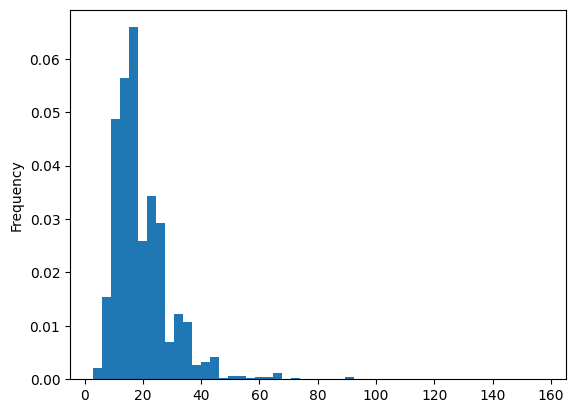

In [48]:
new_data['INCOME TOTAL']=new_data['INCOME TOTAL'].astype(object)
new_data['INCOME TOTAL'] = new_data['INCOME TOTAL']/10000 
print(new_data['INCOME TOTAL'].value_counts(bins=10,sort=False))
new_data['INCOME TOTAL'].plot(kind='hist',bins=50,density=True)

In [49]:
# Create categories using pd.qcut
new_data['gp_inc'] = pd.qcut(
    new_data['INCOME TOTAL'], 
    q=3,  # Number of quantiles
    labels=["low", "medium", "high"]
)

# Calculate IV
iv, data = calc_iv(new_data, 'gp_inc', 'target')

# Update IV table
ivtable.loc[ivtable['variable'] == 'INCOME TOTAL', 'IV'] = iv

# Print results
print(data.head())

This variable's IV is: 0.0024219962214304678
gp_inc
low       8996
high      8244
medium    7894
NULL         0
Name: count, dtype: int64
  Variable   Value   All  Good  Bad     Share  Bad Rate  Distribution Good  \
0   gp_inc    high  8244  8096  148  0.328002  0.017952           0.327614   
1   gp_inc     low  8996  8849  147  0.357922  0.016341           0.358085   
2   gp_inc  medium  7894  7767  127  0.314077  0.016088           0.314301   

   Distribution Bad       WoE        IV  
0          0.350711 -0.068126  0.001573  
1          0.348341  0.027588  0.000269  
2          0.300948  0.043413  0.000580  


(-0.000745, 0.00182]    14663
(0.00182, 0.00337]       8464
(0.00337, 0.00491]       1637
(0.00491, 0.00646]        175
(0.00646, 0.00801]        124
(0.00801, 0.00956]         50
(0.00956, 0.0111]           4
(0.0111, 0.0127]            3
(0.0127, 0.0142]            6
(0.0142, 0.0158]            8
Name: count, dtype: int64
This variable's IV is: 0.0024219962214304678
gp_inc
low       8996
high      8244
medium    7894
NULL         0
Name: count, dtype: int64
  Variable   Value   All  Good  Bad     Share  Bad Rate  Distribution Good  \
0   gp_inc    high  8244  8096  148  0.328002  0.017952           0.327614   
1   gp_inc     low  8996  8849  147  0.357922  0.016341           0.358085   
2   gp_inc  medium  7894  7767  127  0.314077  0.016088           0.314301   

   Distribution Bad       WoE        IV  
0          0.350711 -0.068126  0.001573  
1          0.348341  0.027588  0.000269  
2          0.300948  0.043413  0.000580  


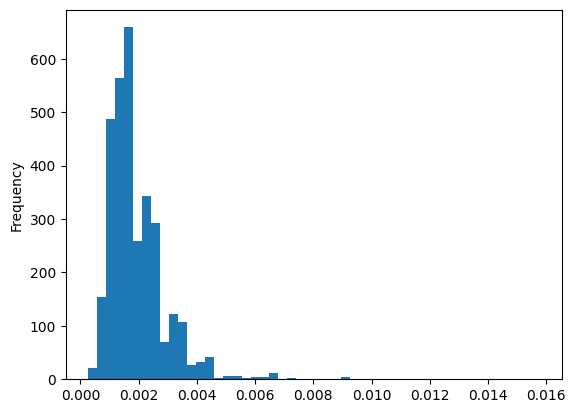

In [50]:
# Convert 'INCOME TOTAL' to numeric and normalize
new_data['INCOME TOTAL'] = new_data['INCOME TOTAL'].astype(float) / 10000

# Print distribution
print(new_data['INCOME TOTAL'].value_counts(bins=10, sort=False))

# Plot histogram
new_data['INCOME TOTAL'].plot(kind='hist', bins=50, density=True)

# Create categories using pd.qcut
new_data['gp_inc'] = pd.qcut(
    new_data['INCOME TOTAL'], 
    q=3,  # Quantiles
    labels=["low", "medium", "high"]
)

# Add 'NULL' as a category to avoid errors when filling NaNs
new_data['gp_inc'] = new_data['gp_inc'].cat.add_categories("NULL").fillna("NULL")

# Calculate IV
iv, data = calc_iv(new_data, 'gp_inc', 'target')

# Update IV table
ivtable.loc[ivtable['variable'] == 'INCOME TOTAL', 'IV'] = iv

# Print results
print(data.head())

In [51]:
new_data = convert_dummy(new_data,'gp_inc')

(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: proportion, dtype: float64
This variable's IV is: 0.02629018578075899
gp_Age
lowest     5634
low        5267
high       4992
highest    4794
medium     4447
NULL          0
Name: count, dtype: int64
IV Data for gp_Age:
     Value  Good  Bad       WoE        IV
0     high  4909   83  0.009946  0.000020
1  highest  4713   81 -0.006408  0.000008
2      low  5200   67  0.281682  0.014551
3   lowest  5517  117 -0.216623  0.011698
4   medium  4373   74  0.009101  0.000015
            variable        IV
3         OWN REALTY  0.027441
10  DAYS SINCE BIRTH   0.02629
1             GENDER  0.025204
5       I

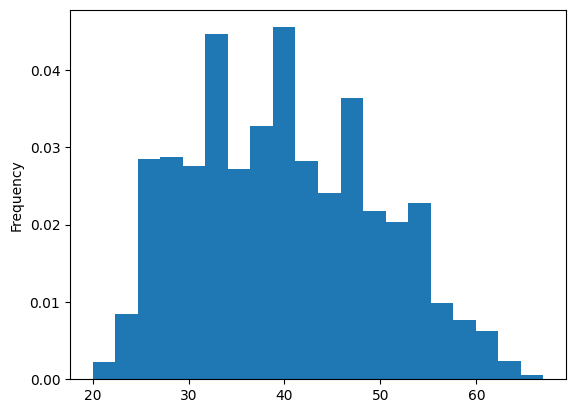

In [52]:
# Calculate Age
new_data['Age'] = -(new_data['DAYS SINCE BIRTH']) // 365

# Check distribution of Age
print(new_data['Age'].value_counts(bins=10, normalize=True, sort=False))
new_data['Age'].plot(kind='hist', bins=20, density=True)

# Step 1: Create age categories
new_data['gp_Age'] = pd.qcut(
    new_data['Age'],
    q=5,  # Number of quantiles
    labels=["lowest", "low", "medium", "high", "highest"]
)

# Step 2: Calculate IV for 'gp_Age'
iv, data = calc_iv(new_data, 'gp_Age', 'target')
print("IV Data for gp_Age:")
print(data[['Value', 'Good', 'Bad', 'WoE', 'IV']])

# Step 3: Update the IV table for 'DAYS SINCE BIRTH'
if 'DAYS SINCE BIRTH' not in ivtable['variable'].values:
    # Append a new row for DAYS SINCE BIRTH if it does not exist
    new_row = pd.DataFrame({'variable': ['DAYS SINCE BIRTH'], 'IV': [0]})
    ivtable = pd.concat([ivtable, new_row], ignore_index=True)

# Update the IV value for DAYS SINCE BIRTH
ivtable.loc[ivtable['variable'] == 'DAYS SINCE BIRTH', 'IV'] = iv

# Step 4: Convert 'gp_Age' to dummy variables
new_data = convert_dummy(new_data, 'gp_Age')

# Step 5: Sort and display the IV table
ivtable = ivtable.sort_values(by='IV', ascending=False)
print(ivtable)


Family Size

In [54]:
# Step 1: Create work experience categories for 'DAYS_EMPLOYED'
new_data['worktm'] = -(new_data['DAYS EMPLOYED']) // 365
new_data.loc[new_data['worktm'] < 0, 'worktm'] = np.nan
new_data['worktm'] = new_data['worktm'].fillna(new_data['worktm'].mean())
new_data = get_category(new_data, 'worktm', 5, ["lowest", "low", "medium", "high", "highest"])

# Step 2: Calculate IV for gp_worktm
iv, data = calc_iv(new_data, 'gp_worktm', 'target')
print("IV Data for gp_worktm:")
print(data[['Value', 'Good', 'Bad', 'WoE', 'IV']])

# Step 3: Update the IV table for DAYS_EMPLOYED
if 'DAYS EMPLOYED' not in ivtable['variable'].values:
    new_row = pd.DataFrame({'variable': ['DAYS EMPLOYED'], 'IV': [0]})
    ivtable = pd.concat([ivtable, new_row], ignore_index=True)
ivtable.loc[ivtable['variable'] == 'DAYS EMPLOYED', 'IV'] = iv

# Step 4: Convert gp_worktm to dummy variables
new_data = convert_dummy(new_data, 'gp_worktm')

# Step 5: Sort and display IV table
ivtable = ivtable.sort_values(by='IV', ascending=False)
print(ivtable)


This variable's IV is: 0.10363020918883244
gp_worktm
lowest     18254
low         4987
medium      1378
high         425
highest       90
Name: count, dtype: int64
IV Data for gp_worktm:
     Value   Good  Bad        WoE        IV
0     high    423    2   1.284186  0.015895
1  highest     90    0  17.410616  0.063409
2      low   4921   66   0.241573  0.010324
3   lowest  17916  338  -0.099635  0.007568
4   medium   1362   16   0.374082  0.006434
            variable        IV
11     DAYS EMPLOYED   0.10363
3         OWN REALTY  0.027441
10  DAYS SINCE BIRTH   0.02629
1             GENDER  0.025204
5       INCOME TOTAL  0.002422
12        WORK PHONE  0.002042
4           CHILDREN  0.001121
13             PHONE  0.000548
14             EMAIL  0.000017
2            OWN CAR  0.000005
0                _id      None
6        INCOME TYPE      None
7     EDUCATION TYPE      None
8      FAMILY STATUS      None
9       HOUSING TYPE      None
15       FAM MEMBERS      None
16              TYPE  

In [55]:
new_data['FAM MEMBERS'].value_counts(sort=False)

FAM MEMBERS
2.0     12697
1.0      4263
5.0       307
3.0      5216
4.0      2576
6.0        51
15.0        3
7.0        18
20.0        1
9.0         2
Name: count, dtype: int64

In [56]:
# Replace NaN or inf values in 'FAM MEMBERS' with a default value (e.g., 0) or handle them
new_data['FAM MEMBERS'] = new_data['FAM MEMBERS'].fillna(0).replace([np.inf, -np.inf], 0).astype(int)

# Create a new grouped column for 'FAM MEMBERS'
new_data['FAM MEMBERS GP'] = new_data['FAM MEMBERS'].astype(object)

# Group families with 3 or more members into a single category
new_data.loc[new_data['FAM MEMBERS GP'] >= 3, 'FAM MEMBERS GP'] = '3more'

# Calculate IV for 'FAM MEMBERS GP'
iv, data = calc_iv(new_data, 'FAM MEMBERS GP', 'target')

# Update IV table for 'FAM MEMBERS'
ivtable.loc[ivtable['variable'] == 'FAM MEMBERS', 'IV'] = iv

# Display the first few rows of the IV DataFrame
print(data.head())

This variable's IV is: 0.006156138507747443
FAM MEMBERS GP
2        12697
3more     8174
1         4263
Name: count, dtype: int64
         Variable  Value    All   Good  Bad     Share  Bad Rate  \
0  FAM MEMBERS GP      1   4263   4179   84  0.169611  0.019704   
1  FAM MEMBERS GP      2  12697  12489  208  0.505172  0.016382   
2  FAM MEMBERS GP  3more   8174   8044  130  0.325217  0.015904   

   Distribution Good  Distribution Bad       WoE        IV  
0           0.169108          0.199052 -0.163028  0.004882  
1           0.505382          0.492891  0.025027  0.000313  
2           0.325510          0.308057  0.055108  0.000962  


In [57]:
new_data = convert_dummy(new_data,'FAM MEMBERS GP')

In [58]:
print(new_data.columns)


Index(['_id', 'ID', 'GENDER', 'OWN CAR', 'OWN REALTY', 'INCOME TOTAL',
       'INCOME TYPE', 'EDUCATION TYPE', 'FAMILY STATUS', 'HOUSING TYPE',
       'DAYS SINCE BIRTH', 'DAYS EMPLOYED', 'MOBIL', 'WORK PHONE', 'PHONE',
       'EMAIL', 'FAM MEMBERS', 'TYPE', 'begin_month', 'past_due', 'target',
       'CHILDREN_1', 'CHILDREN_2More', 'gp_inc_medium', 'gp_inc_high',
       'gp_inc_NULL', 'Age', 'gp_Age_low', 'gp_Age_medium', 'gp_Age_high',
       'gp_Age_highest', 'gp_Age_NULL', 'worktm', 'gp_worktm_high',
       'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium',
       'FAM MEMBERS GP_1', 'FAM MEMBERS GP_3more'],
      dtype='object')


Income Type

In [60]:
# Display value counts for 'INCOME TYPE' without sorting
income_type_counts = new_data['INCOME TYPE'].value_counts(sort=False)
print("Value counts (unsorted):")
print(income_type_counts)

# Display normalized value counts for 'INCOME TYPE' without sorting
income_type_normalized_counts = new_data['INCOME TYPE'].value_counts(normalize=True, sort=False)
print("Normalized value counts (unsorted):")
print(income_type_normalized_counts)

# Consolidate categories for 'INCOME TYPE'
new_data['INCOME TYPE'] = new_data['INCOME TYPE'].replace({'Pensioner': 'State servant', 'Student': 'State servant'})

# Calculate IV for 'INCOME TYPE'
iv, data = calc_iv(new_data, 'INCOME TYPE', 'target')

# Update the IV table
ivtable.loc[ivtable['variable'] == 'INCOME TYPE', 'IV'] = iv

# Display the first few rows of the resulting data
print("First few rows of data after IV calculation:")
print(data.head())


Value counts (unsorted):
INCOME TYPE
Working                 15622
Commercial associate     7052
State servant            2437
Student                    10
Pensioner                  13
Name: count, dtype: int64
Normalized value counts (unsorted):
INCOME TYPE
Working                 0.621549
Commercial associate    0.280576
State servant           0.096960
Student                 0.000398
Pensioner               0.000517
Name: proportion, dtype: float64
This variable's IV is: 5.159303324442013e-05
INCOME TYPE
Working                 15622
Commercial associate     7052
State servant            2460
Name: count, dtype: int64
First few rows of data after IV calculation:
      Variable                 Value    All   Good  Bad     Share  Bad Rate  \
0  INCOME TYPE  Commercial associate   7052   6933  119  0.280576  0.016875   
1  INCOME TYPE         State servant   2460   2418   42  0.097875  0.017073   
2  INCOME TYPE               Working  15622  15361  261  0.621549  0.016707   

   Dis

In [61]:
new_data = convert_dummy(new_data,'INCOME TYPE')

In [62]:
# Group occupations into broader categories
new_data.loc[(new_data['TYPE'] == 'Cleaning staff') | 
             (new_data['TYPE'] == 'Cooking staff') | 
             (new_data['TYPE'] == 'Drivers') | 
             (new_data['TYPE'] == 'Laborers') | 
             (new_data['TYPE'] == 'Low-skill Laborers') | 
             (new_data['TYPE'] == 'Security staff') | 
             (new_data['TYPE'] == 'Waiters/barmen staff'), 'TYPE'] = 'Laborwk'

new_data.loc[(new_data['TYPE'] == 'Accountants') | 
             (new_data['TYPE'] == 'Core staff') | 
             (new_data['TYPE'] == 'HR staff') | 
             (new_data['TYPE'] == 'Medicine staff') | 
             (new_data['TYPE'] == 'Private service staff') | 
             (new_data['TYPE'] == 'Realty agents') | 
             (new_data['TYPE'] == 'Sales staff') | 
             (new_data['TYPE'] == 'Secretaries'), 'TYPE'] = 'officewk'

new_data.loc[(new_data['TYPE'] == 'Managers') | 
             (new_data['TYPE'] == 'High skill tech staff') | 
             (new_data['TYPE'] == 'IT staff'), 'TYPE'] = 'hightecwk'

# Print the value counts for the TYPE column
print(new_data['TYPE'].value_counts())

# Calculate IV for 'TYPE'
iv, data = calc_iv(new_data, 'TYPE', 'target')

# Update the IV table for 'TYPE'
ivtable.loc[ivtable['variable'] == 'TYPE', 'IV'] = iv

# Display the first few rows of the IV DataFrame
print(data.head())


TYPE
Laborwk      10496
officewk     10183
hightecwk     4455
Name: count, dtype: int64
This variable's IV is: 0.004820472061388942
TYPE
Laborwk      10496
officewk     10183
hightecwk     4455
Name: count, dtype: int64
  Variable      Value    All   Good  Bad     Share  Bad Rate  \
0     TYPE    Laborwk  10496  10311  185  0.417602  0.017626   
1     TYPE  hightecwk   4455   4375   80  0.177250  0.017957   
2     TYPE   officewk  10183  10026  157  0.405148  0.015418   

   Distribution Good  Distribution Bad       WoE        IV  
0           0.417247          0.438389 -0.049428  0.001045  
1           0.177039          0.189573 -0.068404  0.000857  
2           0.405714          0.372038  0.086652  0.002918  


In [63]:
new_data = convert_dummy(new_data,'TYPE')

House Type

In [65]:
iv, data=calc_iv(new_data,'HOUSING TYPE','target')
ivtable.loc[ivtable['variable']=='HOUSING TYPE','IV']=iv
data.head()

This variable's IV is: 0.007327502651951503
HOUSING TYPE
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,HOUSING TYPE,Co-op apartment,152,149,3,0.006048,0.019737,0.006029,0.007109,-0.164705,0.000178
1,HOUSING TYPE,House / apartment,22102,21738,364,0.879367,0.016469,0.879654,0.862559,0.019624,0.000335
2,HOUSING TYPE,Municipal apartment,812,793,19,0.032307,0.023399,0.032090,0.045024,-0.338655,0.004380
3,HOUSING TYPE,Office apartment,199,194,5,0.007918,0.025126,0.007850,0.011848,-0.411619,0.001646
4,HOUSING TYPE,Rented apartment,439,433,6,0.017466,0.013667,0.017522,0.014218,0.208939,0.000690


Education

In [67]:
# Consolidate categories for 'EDUCATION TYPE'
new_data.loc[new_data['EDUCATION TYPE'] == 'Academic degree', 'EDUCATION TYPE'] = 'Higher education'

# Calculate IV for 'EDUCATION TYPE'
iv, data = calc_iv(new_data, 'EDUCATION TYPE', 'target')

# Update the IV table
ivtable.loc[ivtable['variable'] == 'EDUCATION TYPE', 'IV'] = iv

# Display the first few rows of the resulting data
print("First few rows of data after IV calculation:")
print(data.head())


This variable's IV is: 0.01036179396573589
EDUCATION TYPE
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: count, dtype: int64
First few rows of data after IV calculation:
         Variable                          Value    All   Good  Bad     Share  \
0  EDUCATION TYPE               Higher education   7146   7018  128  0.284316   
1  EDUCATION TYPE              Incomplete higher    993    972   21  0.039508   
2  EDUCATION TYPE                Lower secondary    187    181    6  0.007440   
3  EDUCATION TYPE  Secondary / secondary special  16808  16541  267  0.668736   

   Bad Rate  Distribution Good  Distribution Bad       WoE        IV  
0  0.017912           0.283992          0.303318 -0.065836  0.001272  
1  0.021148           0.039333          0.049763 -0.235206  0.002453  
2  0.032086           0.007324          0.014218 -0.663301  0.004573  
3  0.015885           0.6

In [68]:
new_data = convert_dummy(new_data,'EDUCATION TYPE')

Marriage Condition

In [70]:
# Display normalized value counts for 'FAMILY STATUS' without sorting
family_status_normalized_counts = new_data['FAMILY STATUS'].value_counts(normalize=True, sort=False)

# Print the results
print("Normalized value counts (unsorted):")
print(family_status_normalized_counts)


Normalized value counts (unsorted):
FAMILY STATUS
Married                 0.696626
Single / not married    0.137065
Civil marriage          0.084865
Separated               0.058367
Widow                   0.023076
Name: proportion, dtype: float64


In [71]:
iv, data=calc_iv(new_data,'FAMILY STATUS','target')
ivtable.loc[ivtable['variable']=='FAMILY STATUS','IV']=iv
data.head()

This variable's IV is: 0.04313711536211955
FAMILY STATUS
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,FAMILY STATUS,Civil marriage,2133,2101,32,0.084865,0.015002,0.085019,0.075829,0.114394,0.001051
1,FAMILY STATUS,Married,17509,17232,277,0.696626,0.015820,0.697313,0.656398,0.060467,0.002474
2,FAMILY STATUS,Separated,1467,1452,15,0.058367,0.010225,0.058757,0.035545,0.502608,0.011666
3,FAMILY STATUS,Single / not married,3445,3362,83,0.137065,0.024093,0.136047,0.196682,-0.368588,0.022349
4,FAMILY STATUS,Widow,580,565,15,0.023076,0.025862,0.022863,0.035545,-0.441263,0.005596


In [72]:
new_data = convert_dummy(new_data,'FAMILY STATUS')

In [73]:
new_data.head()

,_id,ID,GENDER,OWN CAR,OWN REALTY,INCOME TOTAL,HOUSING TYPE,DAYS SINCE BIRTH,DAYS EMPLOYED,MOBIL,...,INCOME TYPE_State servant,TYPE_hightecwk,TYPE_officewk,EDUCATION TYPE_Higher education,EDUCATION TYPE_Incomplete higher,EDUCATION TYPE_Lower secondary,FAMILY STATUS_Civil marriage,FAMILY STATUS_Separated,FAMILY STATUS_Single / not married,FAMILY STATUS_Widow
2,675f8698c31b872d695d0b00,5008806,1,1,1,0.001125,House / apartment,-21474,-1134,1,...,False,False,False,False,False,False,False,False,False,False
3,675f8698c31b872d695d0b01,5008808,0,0,1,0.002700,House / apartment,-19110,-3051,1,...,False,False,True,False,False,False,False,False,True,False
4,675f8698c31b872d695d0b02,5008809,0,0,1,0.002700,House / apartment,-19110,-3051,1,...,False,False,True,False,False,False,False,False,True,False
5,675f8698c31b872d695d0b03,5008810,0,0,1,0.002700,House / apartment,-19110,-3051,1,...,False,False,True,False,False,False,False,False,True,False
6,675f8698c31b872d695d0b04,5008811,0,0,1,0.002700,House / apartment,-19110,-3051,1,...,False,False,True,False,False,False,False,False,True,False


In [74]:
new_data.columns

Index(['_id', 'ID', 'GENDER', 'OWN CAR', 'OWN REALTY', 'INCOME TOTAL',
       'HOUSING TYPE', 'DAYS SINCE BIRTH', 'DAYS EMPLOYED', 'MOBIL',
       'WORK PHONE', 'PHONE', 'EMAIL', 'FAM MEMBERS', 'begin_month',
       'past_due', 'target', 'CHILDREN_1', 'CHILDREN_2More', 'gp_inc_medium',
       'gp_inc_high', 'gp_inc_NULL', 'Age', 'gp_Age_low', 'gp_Age_medium',
       'gp_Age_high', 'gp_Age_highest', 'gp_Age_NULL', 'worktm',
       'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low',
       'gp_worktm_medium', 'FAM MEMBERS GP_1', 'FAM MEMBERS GP_3more',
       'INCOME TYPE_Commercial associate', 'INCOME TYPE_State servant',
       'TYPE_hightecwk', 'TYPE_officewk', 'EDUCATION TYPE_Higher education',
       'EDUCATION TYPE_Incomplete higher', 'EDUCATION TYPE_Lower secondary',
       'FAMILY STATUS_Civil marriage', 'FAMILY STATUS_Separated',
       'FAMILY STATUS_Single / not married', 'FAMILY STATUS_Widow'],
      dtype='object')

In [75]:
ivtable['IV'] = ivtable['IV'].fillna(0)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_5500\2078466997.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ivtable['IV'] = ivtable['IV'].fillna(0)


In [76]:
# Rename variables in ivtable
ivtable.loc[ivtable['variable'] == 'DAYS SINCE BIRTH', 'IV'] = iv
ivtable.loc[ivtable['variable'] == 'DAYS EMPLOYED', 'variable'] = 'DAYS EMPLOYEED'
ivtable.loc[ivtable['variable'] == 'inc', 'variable'] = 'incgp'

# Sort ivtable by IV
ivtable = ivtable.sort_values(by='IV', ascending=False)

# Verify ivtable
print(ivtable)


            variable        IV
11    DAYS EMPLOYEED  0.103630
10  DAYS SINCE BIRTH  0.043137
8      FAMILY STATUS  0.043137
3         OWN REALTY  0.027441
1             GENDER  0.025204
7     EDUCATION TYPE  0.010362
9       HOUSING TYPE  0.007328
15       FAM MEMBERS  0.006156
16              TYPE  0.004820
5       INCOME TOTAL  0.002422
12        WORK PHONE  0.002042
4           CHILDREN  0.001121
13             PHONE  0.000548
6        INCOME TYPE  0.000052
14             EMAIL  0.000017
2            OWN CAR  0.000005
0                _id  0.000000


D:\conda\envs\python3.11_env\Lib\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=10 > n_features=8. There will be no feature selection and all features will be kept.
  warnings.warn(


Selected Features: Index(['GENDER', 'OWN CAR', 'OWN REALTY', 'INCOME TOTAL', 'FAM MEMBERS',
       'DAYS SINCE BIRTH', 'DAYS EMPLOYED', 'Age'],
      dtype='object')
Accuracy Score is 0.70347
Confusion Matrix:
       0     1
0  5196  2218
1  2179  5235


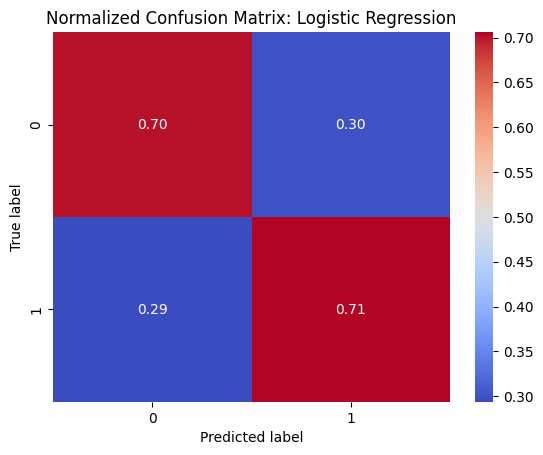

In [77]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt

# Define target (Y) and features (X)
Y = new_data['target'].astype('int')
selected_columns = ['GENDER', 'OWN CAR', 'OWN REALTY', 'INCOME TOTAL', 'FAM MEMBERS',
       'DAYS SINCE BIRTH', 'DAYS EMPLOYED', 'Age']
X = new_data[selected_columns].fillna(0)  

# Check and ensure all columns in X are numeric
numeric_columns = X.select_dtypes(include=['number']).columns
X = X[numeric_columns]

# Apply SMOTE to balance the dataset
sm = SMOTE(random_state=42)
X_balance, Y_balance = sm.fit_resample(X, Y)

# Convert X_balance back to a DataFrame
X_balance = pd.DataFrame(X_balance, columns=X.columns)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balance, Y_balance, 
                                                    stratify=Y_balance, 
                                                    test_size=0.3, 
                                                    random_state=10086)

# Feature Selection: Recursive Feature Elimination (RFE)
model = LogisticRegression(C=0.8, random_state=0, solver='lbfgs', max_iter=1000)
rfe = RFE(estimator=model, n_features_to_select=10)  # Select top 10 features
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

# Reduce dataset to selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Train Logistic Regression Model
model = LogisticRegression(C=0.8, random_state=0, solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_predict = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_predict)
print('Accuracy Score is {:.5f}'.format(accuracy))
print("Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_test, y_predict)))

# Plot the Confusion Matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap='coolwarm'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

cm = confusion_matrix(y_test, y_predict)
class_names = ['0', '1']  # Replace with your actual class labels if necessary
plot_confusion_matrix(cm, class_names, normalize=True, 
                      title='Normalized Confusion Matrix: Logistic Regression')

# plot_confusion_matrix(cm, title, ax, cmap, classes=['0', '1'])

Logistic Regression Accuracy: 0.70347
XGBoost Accuracy: 0.97221
Voting Classifier Accuracy (Logistic Regression + XGBoost): 0.96068

Classification Report for Voting Classifier:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      7414
           1       0.96      0.97      0.96      7414

    accuracy                           0.96     14828
   macro avg       0.96      0.96      0.96     14828
weighted avg       0.96      0.96      0.96     14828



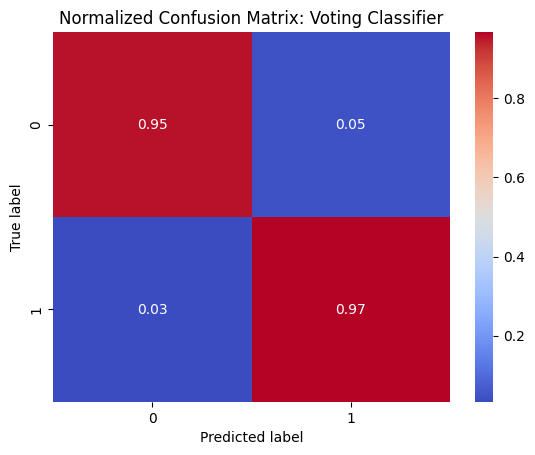

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {lr_accuracy:.5f}")

# 2. XGBoost Model
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f"XGBoost Accuracy: {xgb_accuracy:.5f}")

# 3. Ensemble Voting Classifier with Logistic Regression and XGBoost
voting_model = VotingClassifier(estimators=[
    ('lr', lr_model),   # Logistic Regression
    ('xgb', xgb_model)  # XGBoost
], voting='soft')  # 'soft' uses predicted probabilities

# Train Voting Classifier
voting_model.fit(X_train, y_train)
voting_pred = voting_model.predict(X_test)
voting_accuracy = accuracy_score(y_test, voting_pred)
print(f"Voting Classifier Accuracy (Logistic Regression + XGBoost): {voting_accuracy:.5f}")

# Evaluate Voting Classifier
print("\nClassification Report for Voting Classifier:")
print(classification_report(y_test, voting_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, voting_pred)
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap='coolwarm'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

class_names = ['0', '1']  # Replace with actual class labels if necessary
plot_confusion_matrix(cm, class_names, normalize=True, 
                      title='Normalized Confusion Matrix: Voting Classifier')

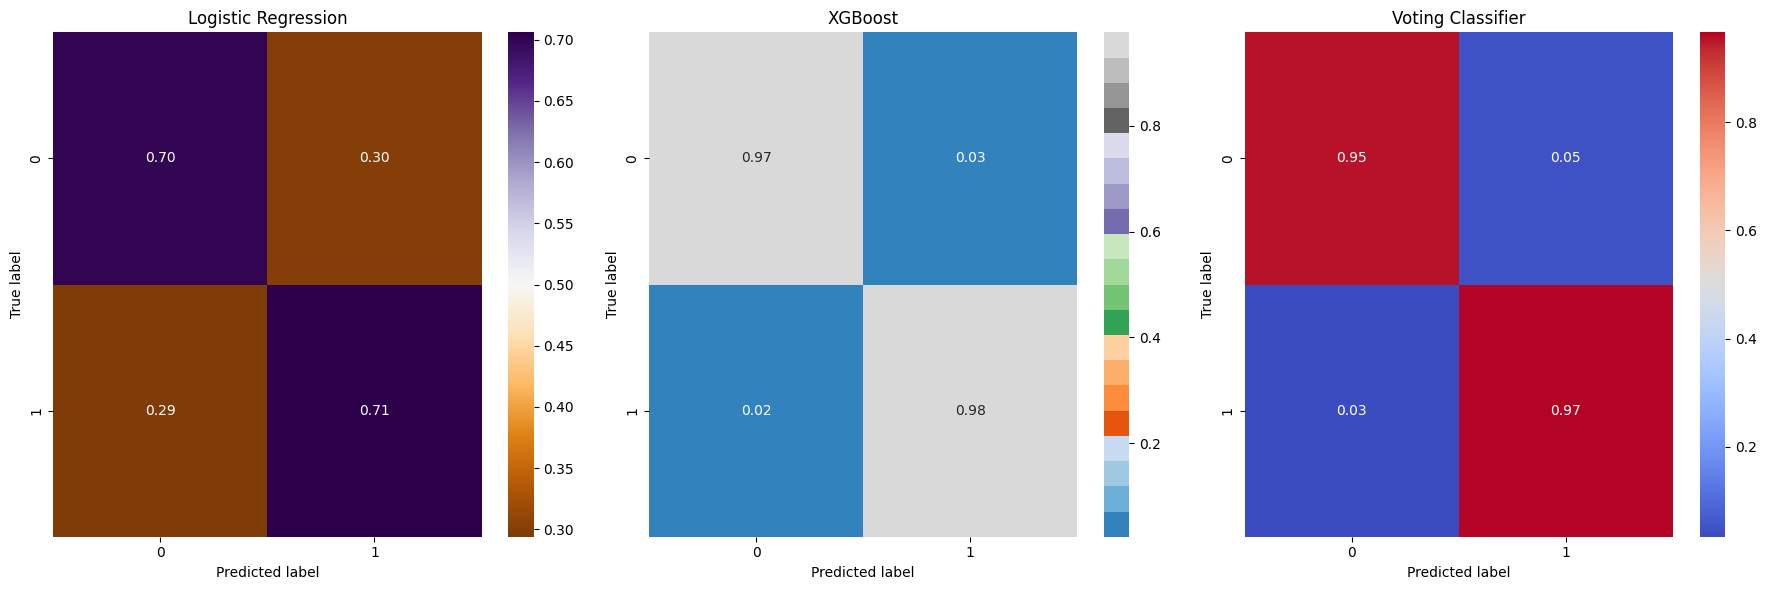

In [79]:
def plot_confusion_matrix(cm, title, ax, cmap, classes=['0', '1']):
    sns.heatmap(cm, annot=True, fmt=".2f", cmap=cmap, xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

# Predictions for all models
lr_pred = lr_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
voting_pred = voting_model.predict(X_test)

# Confusion Matrices
cm_lr = confusion_matrix(y_test, lr_pred)
cm_xgb = confusion_matrix(y_test, xgb_pred)
cm_voting = confusion_matrix(y_test, voting_pred)

# Normalize the confusion matrices
cm_lr_norm = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]
cm_xgb_norm = cm_xgb.astype('float') / cm_xgb.sum(axis=1)[:, np.newaxis]
cm_voting_norm = cm_voting.astype('float') / cm_voting.sum(axis=1)[:, np.newaxis]

# Plot all confusion matrices together
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_confusion_matrix(cm_lr_norm, "Logistic Regression", axes[0], cmap='PuOr')
plot_confusion_matrix(cm_xgb_norm, "XGBoost", axes[1], cmap='tab20c')
plot_confusion_matrix(cm_voting_norm, "Voting Classifier", axes[2], cmap='coolwarm')

plt.tight_layout()
plt.show()

In [91]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# import plotly.express as px
# import plotly.io as pio
# pio.renderers.default = "iframe_connected"  
# selected_columns = ['GENDER', 'OWN CAR', 'OWN REALTY', 'INCOME TOTAL',
#          'FAM MEMBERS', 'CHILDREN_1', 'CHILDREN_2More', 'gp_inc_medium', 'gp_inc_high',
#        'gp_inc_NULL', 'FAM MEMBERS GP_1',
#        'FAM MEMBERS GP_3more', 'INCOME TYPE_Commercial associate',
#         'INCOME TYPE_State servant',
#         'TYPE_Laborwk', 'TYPE_hightecwk',
#        'TYPE_officewk', 
#        'EDUCATION TYPE_Higher education', 'EDUCATION TYPE_Incomplete higher',
#        'EDUCATION TYPE_Lower secondary','DAYS SINCE BIRTH','FAMILY STATUS_Civil marriage','FAMILY STATUS_Separated' ,'FAMILY STATUS_Single / not married',
#                     'FAMILY STATUS_Widow' ,'DAYS EMPLOYED','Age']
# X = new_data[selected_columns].fillna(0)  
# Y = new_data['target']

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# pca = PCA(n_components=3)
# X_pca = pca.fit_transform(X_scaled)

# pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
# pca_df['target'] = Y

# explained_variance = pca.explained_variance_ratio_
# print(f"Explained Variance Ratio: {explained_variance}")
# print(f"Total Explained Variance: {np.sum(explained_variance)}")

# fig = px.scatter_3d(
#     pca_df,
#     x='PCA1',
#     y='PCA2',
#     z='PCA3',
#     color='target',
#     title="PCA 3D Visualization"
# )
# fig.update_traces(marker=dict(opacity=0.5))  

# fig.show()

# Running Neural Networks with only values high on the IV chart

In [ ]:
# Manually specify the selected columns
selected_columns = [
    'GENDER',
    'OWN REALTY',
    'gp_Age_low',
    'gp_Age_medium',
    'gp_Age_high',
    'gp_Age_highest',
    'gp_worktm_high',
    'gp_worktm_highest',
    'gp_worktm_low',
    'gp_worktm_medium',
    'FAMILY STATUS_Civil marriage',
    'FAMILY STATUS_Separated',
    'FAMILY STATUS_Single / not married',
    'FAMILY STATUS_Widow'
]

# we select the high iv columns
Y = new_data['target']
X = new_data[selected_columns]

Y = Y.astype('int')
X_balance,Y_balance = SMOTE().fit_resample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)
													
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = X_train_scaled.shape[1]  # Correct the number of features
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 30
hidden_nodes_layer3 = 10

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation='relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation='relu'))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation='sigmoid'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

# Compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=15)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
# Predict probabilities
y_pred_prob = nn.predict(X_test_scaled)

# Convert probabilities to class predictions (e.g., threshold of 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred))

Performance Interpretation for High-Risk vs. No-Risk
Current Accuracy (65.31%):
Suggests that ~35% of samples are misclassified, but it doesn't reveal if high-risk cases are disproportionately affected.
If high-risk cases are a minority, the model may overfit to predicting the majority (no-risk), inflating accuracy but underperforming where it matters.
Loss (0.6021):
Indicates moderate uncertainty in predictions; may suggest overlap between high- and no-risk feature distributions.

# All columns except target and objects

In [ ]:
# Select all columns with object data type
object_columns = new_data.select_dtypes(include=['object']).columns

# Print the list of object columns
print("Object columns in the DataFrame:")
print(object_columns.tolist())

In [ ]:
# Select all columns excluding object data types and the 'target' column
selected_columns = new_data.select_dtypes(exclude=['object']).drop(columns=['target']).columns.tolist()

# View the resulting list of columns
print(selected_columns)

# we select the high iv columns
Y = new_data['target']
X = new_data[selected_columns]

Y = Y.astype('int')
X_balance,Y_balance = SMOTE().fit_resample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = X_train_scaled.shape[1]  # Correct the number of features
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 30
hidden_nodes_layer3 = 10

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation='relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation='relu'))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation='sigmoid'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

# Compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=15)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
# Predict probabilities
y_pred_prob = nn.predict(X_test_scaled)

# Convert probabilities to class predictions (e.g., threshold of 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred))

Why Such a Large Improvement?
The improvement can be attributed to the inclusion of more features, providing the model with richer information to make decisions:

Feature Completeness:
By excluding only object columns and the target, the model now has access to more relevant numerical and categorical data (potentially after encoding), which contributes to its ability to capture patterns in the data.
Complex Relationships:
More features allow the model to learn complex interactions between variables that were missing when only 5 high-IV features were used.
Diminished Feature Selection Bias:
Relying only on high-IV features may exclude some important interactions or complementary features. Including all numeric columns mitigates this bias.

Accuracy: 97.72%
What is it?
Accuracy measures the proportion of correct predictions (both high-risk and no-risk) relative to the total predictions.
Interpretation:
An accuracy of 97.72% indicates that the model predicts the correct class for most of the samples.
This is a substantial improvement over the previous accuracy of 65.31%, highlighting that the additional features provide more comprehensive information for the model to learn from.

In [ ]:
## random forest

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import itertools

In [95]:
new_data = new_data.drop(columns =['_id' ,'ID','HOUSING TYPE','WORK PHONE','PHONE','EMAIL','past_due'] , errors = 'ignore' )

In [97]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25134 entries, 2 to 36456
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   GENDER                              25134 non-null  int64  
 1   OWN CAR                             25134 non-null  int64  
 2   OWN REALTY                          25134 non-null  int64  
 3   INCOME TOTAL                        25134 non-null  float64
 4   DAYS SINCE BIRTH                    25134 non-null  int64  
 5   DAYS EMPLOYED                       25134 non-null  int64  
 6   MOBIL                               25134 non-null  int64  
 7   FAM MEMBERS                         25134 non-null  int32  
 8   begin_month                         25134 non-null  float64
 9   target                              25134 non-null  int64  
 10  CHILDREN_1                          25134 non-null  bool   
 11  CHILDREN_2More                      25134 non-

In [99]:
new_data.columns

Index(['GENDER', 'OWN CAR', 'OWN REALTY', 'INCOME TOTAL', 'DAYS SINCE BIRTH',
       'DAYS EMPLOYED', 'MOBIL', 'FAM MEMBERS', 'begin_month', 'target',
       'CHILDREN_1', 'CHILDREN_2More', 'gp_inc_medium', 'gp_inc_high',
       'gp_inc_NULL', 'Age', 'gp_Age_low', 'gp_Age_medium', 'gp_Age_high',
       'gp_Age_highest', 'gp_Age_NULL', 'worktm', 'gp_worktm_high',
       'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium',
       'FAM MEMBERS GP_1', 'FAM MEMBERS GP_3more',
       'INCOME TYPE_Commercial associate', 'INCOME TYPE_State servant',
       'TYPE_hightecwk', 'TYPE_officewk', 'EDUCATION TYPE_Higher education',
       'EDUCATION TYPE_Incomplete higher', 'EDUCATION TYPE_Lower secondary',
       'FAMILY STATUS_Civil marriage', 'FAMILY STATUS_Separated',
       'FAMILY STATUS_Single / not married', 'FAMILY STATUS_Widow'],
      dtype='object')

In [119]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap='coolwarm'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# we select the high iv columns
selected_columns = ['GENDER', 'OWN CAR', 'OWN REALTY', 'INCOME TOTAL',
         'FAM MEMBERS', 'CHILDREN_1', 'CHILDREN_2More', 'gp_inc_medium', 'gp_inc_high',
       'gp_inc_NULL', 'FAM MEMBERS GP_1',
       'FAM MEMBERS GP_3more', 'INCOME TYPE_Commercial associate',
        'INCOME TYPE_State servant',
         'TYPE_hightecwk',
       'TYPE_officewk', 
       'EDUCATION TYPE_Higher education', 'EDUCATION TYPE_Incomplete higher',
       'EDUCATION TYPE_Lower secondary']
def train(X,Y, show = True):
    Y = Y.astype('int')
    X_balance,Y_balance = SMOTE().fit_resample(X,Y)
    X_balance = pd.DataFrame(X_balance, columns = X.columns)
    X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

    model = RandomForestClassifier(n_estimators=250,
                                  max_depth=12,
                                  min_samples_leaf=16
                                  )
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
    if show:
        print(pd.DataFrame(confusion_matrix(y_test,y_predict)))
        class_names = ['0','1']
        plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                              classes=class_names, normalize = True, 
                              title='Normalized Confusion Matrix: Ramdom Forests')

    
Y = new_data['target']
X = new_data[selected_columns]

Accuracy Score is 0.88569
      0     1
0  6431   983
1   712  6702


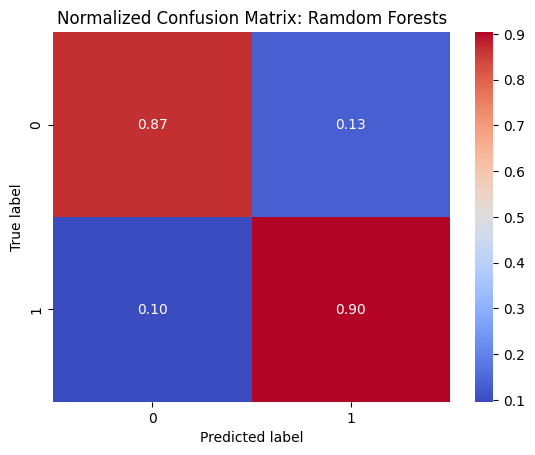

In [121]:
train(X,Y)

In [123]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe_connected"  

X = new_data[selected_columns].fillna(0)  
Y = new_data['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
pca_df['target'] = Y

explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance}")
print(f"Total Explained Variance: {np.sum(explained_variance)}")

fig = px.scatter_3d(
    pca_df,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='target',
    title="PCA 3D Visualization"
)
fig.update_traces(marker=dict(opacity=0.5))  

fig.show()


Explained Variance Ratio: [0.15838996 0.13096054 0.08737029]
Total Explained Variance: 0.3767207863169737


In [ ]:
# static png

![alt text](iframe_figures/pca_scatter.png)

In [124]:
# try1 : try the highest iv columns

In [125]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25134 entries, 2 to 36456
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   GENDER                              25134 non-null  int64  
 1   OWN CAR                             25134 non-null  int64  
 2   OWN REALTY                          25134 non-null  int64  
 3   INCOME TOTAL                        25134 non-null  float64
 4   DAYS SINCE BIRTH                    25134 non-null  int64  
 5   DAYS EMPLOYED                       25134 non-null  int64  
 6   MOBIL                               25134 non-null  int64  
 7   FAM MEMBERS                         25134 non-null  int32  
 8   begin_month                         25134 non-null  float64
 9   target                              25134 non-null  int64  
 10  CHILDREN_1                          25134 non-null  bool   
 11  CHILDREN_2More                      25134 non-

Accuracy Score is 0.97444
      0     1
0  7292   122
1   257  7157


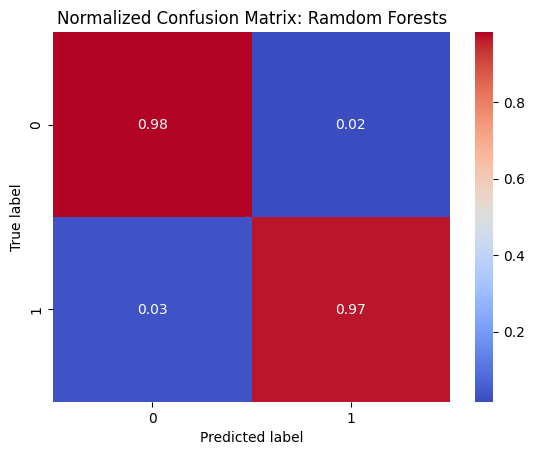

In [127]:
selected_columns = ['GENDER', 'OWN CAR', 'OWN REALTY', 'INCOME TOTAL',
         'FAM MEMBERS', 'CHILDREN_1', 'CHILDREN_2More', 'gp_inc_medium', 'gp_inc_high',
       'gp_inc_NULL', 'FAM MEMBERS GP_1',
       'FAM MEMBERS GP_3more', 'INCOME TYPE_Commercial associate',
        'INCOME TYPE_State servant',
         'TYPE_hightecwk',
       'TYPE_officewk', 
       'EDUCATION TYPE_Higher education', 'EDUCATION TYPE_Incomplete higher',
       'EDUCATION TYPE_Lower secondary','DAYS SINCE BIRTH','FAMILY STATUS_Civil marriage','FAMILY STATUS_Separated' ,'FAMILY STATUS_Single / not married',
                    'FAMILY STATUS_Widow' ,'DAYS EMPLOYED','Age'
 ]

Y = new_data['target']
X = new_data[selected_columns]
train(X,Y)

Accuracy Score is 0.97559
      0     1
0  7267   147
1   215  7199


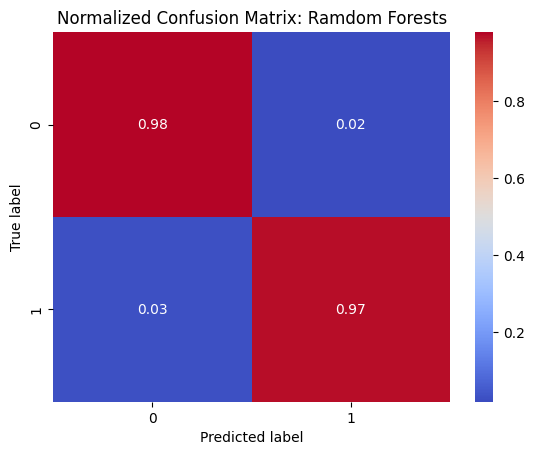

38

In [140]:
# try2 : try the all the  columns

selected_columns = list(new_data.columns)
selected_columns.remove('target')
Y = new_data['target']
X = new_data[selected_columns]
train(X,Y)
len(selected_columns)

Accuracy Score is 0.90599
      0     1
0  6597   817
1   577  6837


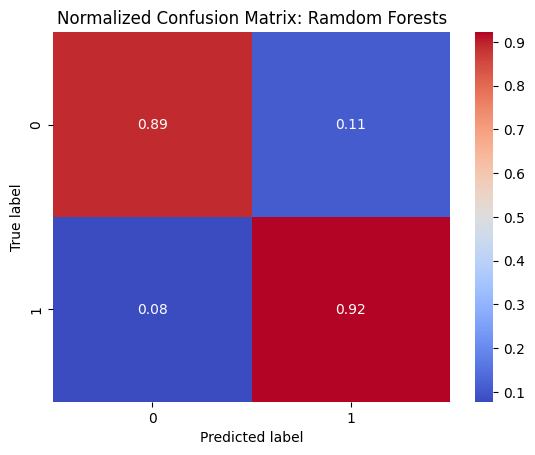

In [129]:
# try3 : try only the all the ivtable  columns
selected_columns =  list(ivtable['variable'])[:-1]
selected_columns = set(selected_columns)
selected_columns -= {'FAMILY STATUS', 'DAYS EMPLOYEED', 'HOUSING TYPE', 'EDUCATION TYPE', 'TYPE', 'INCOME TYPE', 'WORK PHONE', 'CHILDREN', 'EMAIL', 'PHONE'}
selected_columns = list(selected_columns)
Y = new_data['target']
X = new_data[selected_columns]
train(X,Y)

In [133]:
# try4 :  forword select 
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

all_columns = list(new_data.columns)
all_columns.remove('target')

Y = new_data['target']
X = new_data[all_columns]

for k in range(1,len(all_columns)):
    sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                    k_features=k,
                                    forward=True,
                                    scoring='accuracy',
                                    cv=None)
    sfs.fit(X, Y)
    
    selected_columns = list(sfs.k_feature_names_)
    X_selected = new_data[selected_columns]
    print(f"forward select in top {k} , columns : {selected_columns} ")
    train(X_selected,Y,show = False)

forward select in top 1 , columns : ['GENDER'] 
Accuracy Score is 0.54208
forward select in top 2 , columns : ['GENDER', 'OWN CAR'] 
Accuracy Score is 0.53507
forward select in top 3 , columns : ['GENDER', 'OWN CAR', 'OWN REALTY'] 
Accuracy Score is 0.54498
forward select in top 4 , columns : ['GENDER', 'OWN CAR', 'OWN REALTY', 'INCOME TOTAL'] 
Accuracy Score is 0.73698
forward select in top 5 , columns : ['GENDER', 'OWN CAR', 'OWN REALTY', 'INCOME TOTAL', 'DAYS SINCE BIRTH'] 
Accuracy Score is 0.9244
forward select in top 6 , columns : ['GENDER', 'OWN CAR', 'OWN REALTY', 'INCOME TOTAL', 'DAYS SINCE BIRTH', 'DAYS EMPLOYED'] 
Accuracy Score is 0.92636
forward select in top 7 , columns : ['GENDER', 'OWN CAR', 'OWN REALTY', 'INCOME TOTAL', 'DAYS SINCE BIRTH', 'DAYS EMPLOYED', 'MOBIL'] 
Accuracy Score is 0.92487
forward select in top 8 , columns : ['GENDER', 'OWN CAR', 'OWN REALTY', 'INCOME TOTAL', 'DAYS SINCE BIRTH', 'DAYS EMPLOYED', 'MOBIL', 'FAM MEMBERS'] 
Accuracy Score is 0.92541
forw


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

TypeError: 'NoneType' object is not iterable

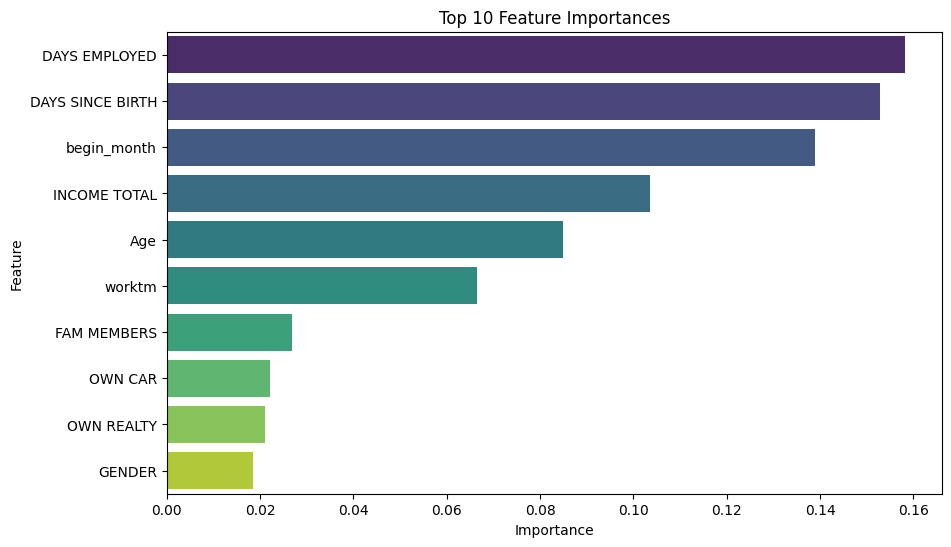

In [142]:
selected_columns = ['GENDER', 'OWN CAR', 'OWN REALTY', 'INCOME TOTAL',
         'FAM MEMBERS', 'CHILDREN_1', 'CHILDREN_2More', 'gp_inc_medium', 'gp_inc_high',
       'gp_inc_NULL', 'FAM MEMBERS GP_1',
       'FAM MEMBERS GP_3more', 'INCOME TYPE_Commercial associate',
        'INCOME TYPE_State servant',
         'TYPE_hightecwk',
       'TYPE_officewk', 
       'EDUCATION TYPE_Higher education', 'EDUCATION TYPE_Incomplete higher',
       'EDUCATION TYPE_Lower secondary','DAYS SINCE BIRTH','FAMILY STATUS_Civil marriage','FAMILY STATUS_Separated' ,'FAMILY STATUS_Single / not married',
                    'FAMILY STATUS_Widow' ,'DAYS EMPLOYED','Age'
 ]

model = RandomForestClassifier(n_estimators=250,
                              max_depth=12,
                              min_samples_leaf=16
                              )

model.fit(X, Y)

feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
})

top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

 From the normalized confusion matrix, the following conclusions can be drawn:

**Classifier Performance**:
   - For class `0`  means no risk, (true label = 0), the classifier achieved an accuracy of **98%** (0.98), meaning most samples with a true label of 0( no risk ) were correctly classified.
   - For class `1`  means have risk (true label = 1), the classifier achieved a higher accuracy of **97%** (0.97), indicating stronger performance in identifying class 1 (have risk).

**Summary**: The model demonstrates good overall performance, but the relatively high misclassification rate for class 0 indicates room for improvement.

We conducted a comparative analysis of the model training results from Test 1 and Test 2.

In Test 1, we selected over 30 key columns, including those related to economic status and family factors, to serve as predictors in a Random Forest-based model. The model achieved an accuracy of 98% in predicting "No Risk" and 97% in predicting "Risk," resulting in an overall accuracy of 97.7%.

To enhance the model's precision, Test 2 incorporated all available columns from the dataset for training. The results demonstrated that the accuracy for both "No Risk" and "Risk" predictions remained consistent across the tests. This comparison affirmed the robustness and predictive reliability of the model.

Furthermore, a feature importance analysis conducted using the Random Forest algorithm identified three columns with significant influence on credit card approval decisions and the classification of high-risk users: job tenure, age, and the month when credit card delinquency first occurred. These insights provide a valuable foundation for improving credit risk assessment and optimizing the credit card approval process.